In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
if not os.path.exists("/content/drive/MyDrive/age_gender_classification/UTKFace"):
  os.makedirs("/content/drive/MyDrive/age_gender_classification/UTKFace")

In [3]:
cd /content/drive/MyDrive/age_gender_classification/UTKFace

/content/drive/MyDrive/age_gender_classification/UTKFace


In [4]:
pwd

'/content/drive/MyDrive/age_gender_classification/UTKFace'

In [5]:
# !unrar e /content/drive/MyDrive/age_gender_classification/UTKFace/UTKFace.rar 

# Building a multi-output model with Keras

In this notebook, we will be covering some basics of what is a multi-output model in Keras and how we can take advantage of it when building our Deep Learning models. We will be using the UTK dataset, which contains pictures of people from diverse gender, races and ages.

In [6]:
# dataset_folder_name = '/media/kongbe/New Volume1/dataset/UTKFace'   # data path in local computer
dataset_folder_name = "/content/drive/MyDrive/age_gender_classification/UTKFace"# Data's path in google colab
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    # 'race_id': {
    #     0: 'white', 
    #     1: 'black', 
    #     2: 'asian', 
    #     3: 'indian', 
    #     4: 'others'
    # },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

# dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
# dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [7]:
print(dataset_dict)

{'gender_id': {0: 'male', 1: 'female'}}


In [8]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's also define a method to help us on extracting the data from our dataset. This function will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender and sex) of our records.

In [9]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, _, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)]
        except Exception as ex:
            return None, None

    # files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    files = [os.path.join(dataset_folder_name,i) for i in os.listdir(dataset_path)]
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'path_file']
    df = df.dropna()
    
    return df
    # return files

In [10]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,path_file
0,36.0,female,/content/drive/MyDrive/age_gender_classificati...
1,36.0,female,/content/drive/MyDrive/age_gender_classificati...
2,36.0,female,/content/drive/MyDrive/age_gender_classificati...
3,36.0,female,/content/drive/MyDrive/age_gender_classificati...
4,36.0,female,/content/drive/MyDrive/age_gender_classificati...


# Data visualization

As an important step to understand not only the distribution of our dataset, but as well the predictions generated by our model, we need to perform some data visualization process on our dataset.

Let's then define a helper function to generate pie plots based on a given Pandas series:

In [12]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))

Let's start by plotting the race distribution with our predefined plot_distribution method.

From a quick glance, we can see that we have almost half of the samples being from the white race, so we can expect to have a great accuracy on this given class. Other races such as black, indian and asian also show a good number of samples, probably leading us to good accuracy numbers. The race 'others' (hispanics, latinos, etc) on the other side, show a small number of samples, which may lead to a small accuracy.

For both male and female samples, we have quite a good balanced number of records, so we should have a great accuracy for both classes when using our model.

### Age distribution

Let's also plot how our age feature is distributed over the dataset by using a simple histogram with 20 bins.

In [15]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

We can observe that our dataset is mostly composed of individuals which age varies between 20 and 30 years, followed by individuals ranging from 30-40 years and then 40-60 years old. These groups represent around 70% of our dataset, so we can believe that we are going to have a good accuracy on predicting individuals in these ranges.

We could also perform some multi-variate analysis on our dataset, but since the scope of this notebook is to demonstrate the usage of a multi-output model with Keras, we won't be covering it.

# Data preparation

In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [11]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
import tensorflow.keras
import cv2

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        # self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = cv2.imread(img_path, cv2.IMREAD_COLOR)
        im = cv2.resize(im, (IM_WIDTH, IM_HEIGHT))
        im = np.array(im, dtype=np.float32) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, genders = [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                if person['gender'] == 'male':
                  gender = 0
                else:
                  gender = 1 
                file = person['path_file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(genders)]
                    images, ages, genders = [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [12]:
batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
print(len(test_idx))

7232


## Building our model

In this step, we will define our multi-output Keras model. Our model will be composed of three major branches, one for each available feature: age, gender and race. The default structure for our convolutional layers is based on a Conv2D layer with a ReLU activation, followed by a BatchNormalization layer, a MaxPooling and finally a Dropout layer. Each of these default layers is then followed by the final layer for each feature, composed by a Dense layer.

These default layers are defined on the make_default_hidden_layers method, which will be reused on building each of the branches of our model.

In [13]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):                 
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    # def build_race_branch(self, inputs, num_races):
    #     """
    #     Used to build the race branch of our face recognition network.
    #     This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    #     followed by the Dense output layer.
    #     """
    #     x = self.make_default_hidden_layers(inputs)

    #     x = Flatten()(x)
    #     x = Dense(128)(x)
    #     x = Activation("relu")(x)
    #     x = BatchNormalization()(x)
    #     x = Dropout(0.5)(x)
    #     x = Dense(num_races)(x)
    #     x = Activation("softmax", name="race_output")(x)

    #     return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        # x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        # race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)

Let's give a look into our model structure and summary, to have a better understanding of what we are building.

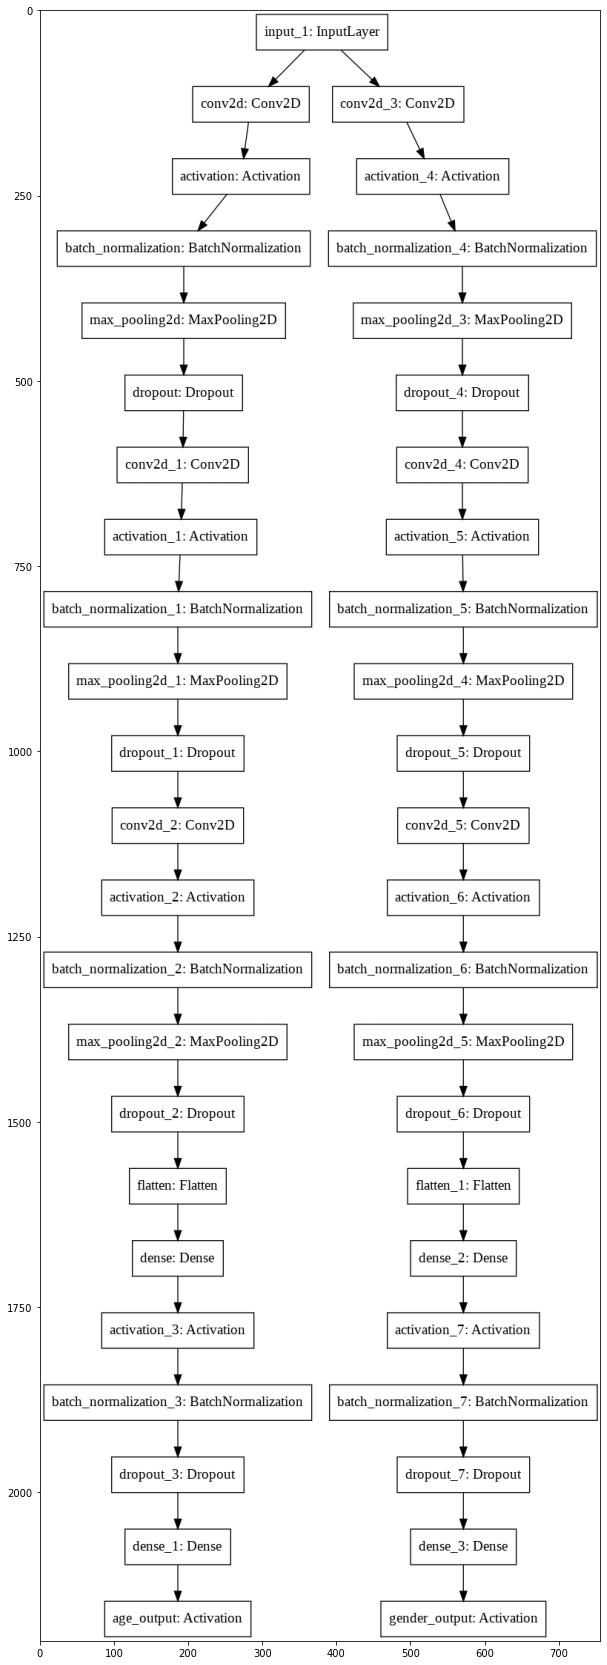

In [14]:
%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [15]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 198, 198, 16) 0           conv2d[0][0]                     
___________________________________________________________________________________________

## Training our model

Now it's time to train our multi-output model, once we already have everything done. But before doing it, we need to compile our model. For this step, let's use a learning rate of 0.0004 and an Adam optimizer. We will also use custom loss weights for each feature and a custom loss function for each feature.

When building our optimizer, let's use a decay based on the learning rate divided by the number of epochs, so we will slowly be decreasing our learning rate over the epochs.

In [16]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 200

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4.,  
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

And now let's train our model with a batch size of 32 for both valid and train sets. We will be using a ModelCheckpoint callback in order to save the model on disk at the end of each epoch.

In [17]:
def ckpt_path2epoch(checkpoint_path):
  """
  Input: Checkpoint path 
  Output: Previous epoch index for continuing to train
  """
  cp = checkpoint_path.split("/")[-1]
  epoch_index = int(cp.split("-")[-1].split(".")[0])
  return epoch_index

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

continue_training = True

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

checkpoint_path = "/content/drive/MyDrive/age_gender_classification/model_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, 
                    monitor="val_loss",
                    verbose=1,
                    save_weights_only=True)]

latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

if continue_training == True:
  previous_epoch = ckpt_path2epoch(latest_ckpt)
else:
  previous_epoch = 0

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size,
                    initial_epoch=previous_epoch)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: ignored

In [20]:
os.listdir(checkpoint_dir)

['cp-0001.ckpt.index',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0016.ckpt.index',
 'cp-0017.ckpt.data-00000-of-00001',
 'c

Let's plot our losses and accuracy curves for each feature:

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

test_model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)
init_lr = 1e-4
epochs = 200

opt = Adam(lr=init_lr, decay=init_lr / epochs)

test_model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4.,  
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})
test_model.load_weights("/content/drive/MyDrive/age_gender_classification/model_checkpoint/cp-0128.ckpt")
# test_gen = data_generator.generate_images(test_idx, 
#                                           is_training= True,
#                                           batch_size=batch_size)
# results = test_model.evaluate(test_gen, 
#                               steps=len(test_idx)//batch_size,
#                               verbose=1)
# checkpoint_path = "/content/drive/MyDrive/age_gender_classification/model_checkpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# if not os.path.exists(checkpoint_dir):
#   os.makedirs(checkpoint_dir)

# callbacks = [
#     ModelCheckpoint(filepath=checkpoint_path, 
#                     monitor="val_loss",
#                     verbose=1,
#                     save_weights_only=True)
# ]

# history1 = test_model.fit(train_gen,
#                     steps_per_epoch=len(train_idx)//batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     callbacks=callbacks,
#                     validation_data=valid_gen,
#                     validation_steps=len(valid_idx)//batch_size,
#                     initial_epoch=70)

## Evaluating our model on the test set

In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the predict_generator method from our trained model, which will output our the predictions for the test set.

In [36]:
test_batch_size = 32
test_generator = data_generator.generate_images(test_idx[:200], 
                                                is_training=False,
                                                batch_size=test_batch_size)
age_pred, gender_pred = test_model.predict_generator(test_generator, 
                                                steps=len(test_idx[:200])//test_batch_size,
                                                verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


6/6 [==============================] - 2s 380ms/step


In [22]:
print("----------------------------------------Start evaluating---------------------------------------")
test_batch_size = 32
test_generator = data_generator.generate_images(test_idx[:200], 
                                                is_training=False,
                                                batch_size=test_batch_size)
test_model.evaluate(test_generator,
                    verbose=1,
                    steps=len(test_idx[:2000])//test_batch_size,
                    batch_size=test_batch_size)

----------------------------------------Start evaluating---------------------------------------
62/62 [==============================] - 503s 8s/step - loss: 0.2935 - age_output_loss: 0.0662 - gender_output_loss: 0.2857 - age_output_mae: 0.1129 - gender_output_accuracy: 0.9048


[0.3897286653518677,
 0.09108062088489532,
 0.2540625035762787,
 0.11482281982898712,
 0.9153226017951965]

Let's iterate one time over all our test samples, in order to have their labels into a single list. We will also extract the arg max of each record, in order to retrieve the top predictions and ground truths.

In [37]:
test_generator = data_generator.generate_images(test_idx[:200], is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, gender_true = [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    gender_true.extend(labels[1])
    
age_true = np.array(age_true)
gender_true = np.array(gender_true)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [38]:
age_pred

array([[ 35.44326  ],
       [-94.032326 ],
       [ 42.393593 ],
       [ 27.467697 ],
       [ 49.96182  ],
       [ 26.126984 ],
       [ 98.98466  ],
       [ 33.841198 ],
       [ 21.55667  ],
       [ 42.355946 ],
       [ 26.418146 ],
       [ 14.291998 ],
       [ 30.631397 ],
       [ 42.21839  ],
       [ 24.578516 ],
       [125.04538  ],
       [ 42.771168 ],
       [ 31.997    ],
       [ 39.545387 ],
       [ 33.736607 ],
       [ 25.57055  ],
       [ 12.330526 ],
       [ 24.719353 ],
       [ 61.013866 ],
       [ 27.096512 ],
       [ 36.629036 ],
       [ 29.294292 ],
       [ 83.73721  ],
       [ 25.896738 ],
       [ 46.452263 ],
       [  7.684607 ],
       [ 36.286167 ],
       [ 39.63776  ],
       [ 94.043076 ],
       [ 12.65915  ],
       [ 34.80515  ],
       [ 40.61216  ],
       [ 36.50785  ],
       [ -6.339413 ],
       [  4.114754 ],
       [ 31.361324 ],
       [ 33.58281  ],
       [ 40.512215 ],
       [ 30.11123  ],
       [ 16.565407 ],
       [ 2

In [39]:
for i in gender_pred:
  for j in range(0,2):
    if i[j]<0.5:
      i[j]=0
    else: 
      i[j]=1
# print(gender_pred)

In [40]:
# np.expand_dims(age_true, axis=0)
# print(age_true.shape)
# print(gender_true[0][0])

### Example of predictions

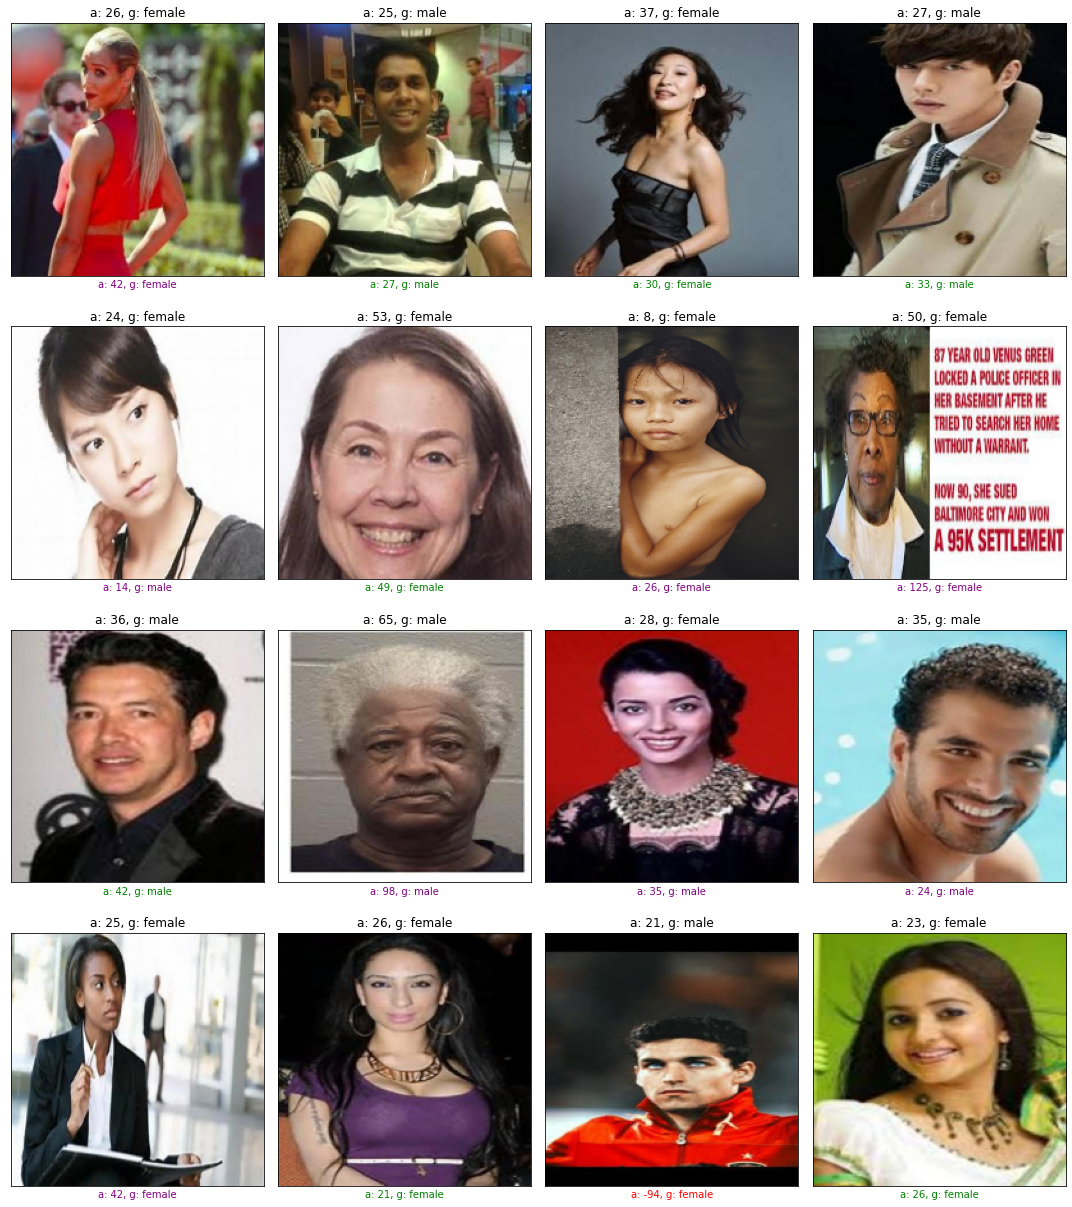

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt

n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(cv2.cvtColor(images[img_idx], cv2.COLOR_BGR2RGB))
   
    # plt.imshow(cv2.cvtColor(image[img_idx], cv2.COLOR_BGR2RGB))

    cur_age_pred = age_pred[img_idx][0]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx][0]
    cur_gender_true = gender_true[img_idx][0]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true  and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    else:
        ax.xaxis.label.set_color('purple')
    ax.set_xlabel('a: {}, g: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx][1]]))
    
    ax.set_title('a: {}, g: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx][1]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

# References

UTK Face Dataset: http://aicip.eecs.utk.edu/wiki/UTKFace

Keras Multi-output documentation: https://keras.io/getting-started/functional-api-guide/

SanjayaSubedi post on multi-output model: https://sanjayasubedi.com.np/deeplearning/multioutput-keras/

PyImageSearch post on FashionNet: https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

Plotly: https://plot.ly/